# Исследование объявлений о продаже квартир


В моем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. <br>
Цели исследования: Проверить, какие существуют закономерности, влияющие на разные факторы продажи квартир и какие есть тенденции среди публикуемых объявлений по другим признакам.<br>

Для достижения целей, необходимо:
- Изучить предоставленную информацию
- Проверить на наличие пропусков и аномальных значений, по возможности избавиться от них
- Добавить новые столбцы с данными для облегчения и наглядности анализа
- С помощью наглядных графиков проанализировать общие тенденции по каждому признаку
- Найти взаимосвязи стоимости недвижимости с другими факторами: городом, этажом, площадью, датой публикации
- Определить средние, максимальные и милимальные сроки продажи недвижимости
- Определить населенные пункты с самыми дорогими предложениями
- Посмотреть, как меняется стоимость при отдалении от центра города
- Сделать общие выводы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn


try:
    df = pd.read_csv('/Users/janna/Downloads/real_estate_data.csv', sep='\t')

except:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
    
    
display(df.head()) #открыла датафрейм и посмотрела, как выглядит 


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
df.isna().sum() #проверка пропусков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Видим, что пропуски есть в большинстве столбцов.</p>

ceiling_height высота потолков, ***пропустить***. Вероятно, хозяева не знают точную высоту, а документы доставать было лень. <br>
floors_total всего этажей, ***оставить пропуски*** <br>
living_area жилая площадь, важный параметр. Можно ***заполнить средним*** по количеству комнат<br>
is_apartment аппартаменты. Вероятно, если не заполнено, то это не аппарты, поэтому всё ***пустое заполнить false*** <br>
kitchen_area площадь кухни,***пропустить***. Не заполнено, потому что собственник не знает и не захотел смотреть в документах<br>
balcony наличие балкона, если не заполнено, но скорей всего их нет. ***Заполнить нулями*** <br>
locality_name — название населённого пункта, придется ***удалить пропуски***, так как не получится сортировать, не заполнено случайно, скорей всего, так как таких пропусков не много<br>
parks_around3000 — число парков в радиусе 3 км, ***оставить пропуски***. Не заполнено, потому что не было указано точного адреса?<br>
parks_nearest — расстояние до ближайшего парка (м), ***оставить пропуски*** <br>
ponds_around3000 — число водоёмов в радиусе 3 км, ***оставить пропуски*** <br>
ponds_nearest — расстояние до ближайшего водоёма (м), ***оставить пропуски***<br>
days_exposition сколько дней было размещено объявление. Очень важный фактор, но выявить закономерность вряд ли получится, поэтому ***пропустить***


### Замена пропусков


In [5]:
df['balcony'] = df['balcony'].fillna(0) #заполнение пропусков с балконами на нули
df['is_apartment'] = df['is_apartment'].fillna(False) #заполнение ячеек с апартаментами

Вывод: данные на большом количестве комнат начинают увеличиваться не пропорционально, но это не повлияет за заполнение, так как количество таких предложений единично

In [10]:
mean_area_2 = (df['living_area']/df['total_area']).mean() #коэффициент отношения жилой площади к общей
print(round(mean_area_2, 2))

0.56


In [11]:
df['living_area'] = df['living_area'].fillna(df['total_area']*mean_area_2) #заполнение пропусков, путем умножения
#общей площади на коэффициент

In [12]:
mean_kitchen = (df['kitchen_area']/df['total_area']).mean() #коэффициент отношения площади кухни к жилой
print(round(mean_kitchen, 2))


0.19


In [13]:
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area']*mean_kitchen) #заполнение пропусков, путем умножения
#общей площади на коэффициент


In [14]:
#проверка
df['living_area'].isna().sum()
df['kitchen_area'].isna().sum()

0

In [15]:
df = df.dropna(subset = ['locality_name'])#удаляю все строки, где пропущен населенный пункт


#### Вывод
- Заменила пропуски в информации о балконах на нули
- Заполнила пустые ячейки с признаком аппартаментов
- Заполнила  пропущенные значения в площади в зависимости от количества компант
- Удалила строки, где пропущен населенный пункт

### Изменение типов данных

In [16]:
#функция, чтобы заменить Nan на None в столбце с днями
def nan_func(row):
    if row != row:
        row = None
    return row
df['days_exposition'] = df['days_exposition'].apply(nan_func)

In [17]:
#df['days_exposition'] = df['days_exposition'].fillna('None')

In [18]:
#df['days_exposition'] = df['days_exposition'].astype('int')

In [19]:
df['is_apartment'] = df['is_apartment'].astype('bool')

In [20]:
display(df.head())
df.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,...,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.600000,1,False,...,11.000000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.300000,4,False,...,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,89.797718,9,False,...,29.789403,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,False,...,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Изучение уникальных значений


In [21]:
print(df['locality_name'].unique()) #посмотрела уникальные значения
print()
print('Всего уникальных значений', len(df['locality_name'].unique())) #проверила, сколько их всего

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [22]:
df['locality_name'] = df['locality_name'].str.replace('посёлок', 'поселок') #замена значений
df['locality_name'] = df['locality_name'].str.replace('городской поселок', 'поселок городского типа') #замена значений
print(len(df['locality_name'].unique())) #проверка, сколько уникальных значений осталось

323


#### Вывод
При заполнении населенного пункта не было четкого образца, поэтому пользователи заполняли пункт по разному. Путем замены двух значений удалось избавиться от 41 дубля. Чтобы такого не происходило, для заполнения необходим единый справочник населенных пунков, из которого можно выбрать необходимый и нельзя вписать рандомный

### Поиск редких и выбивающихся значений


In [23]:
print(sorted(df['ceiling_height'].unique()))

[1.0, 2.0, 2.3, 2.4, 2.45, 2.46, 2.48, 2.53, 2.59, 2.62, 2.63, 2.7, nan, 1.2, 1.75, 2.2, 2.25, 2.34, 2.47, 2.49, 2.5, 2.51, 2.52, 2.54, 2.55, 2.56, 2.57, 2.58, 2.6, 2.61, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.0, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2, 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3, 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6, 3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7, 3.75, 3.76, 3.78, 3.8, 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.9, 3.93, 3.95, 3.98, 4.0, 4.06, 4.1, 4.14, 4.15, 4.19, 4.2, 4.25, 4.3, 4.37, 4.4, 4.45, 4.5, 4.65, 4.7, 4.8, 4.9, 5.0, 5.2, 5.3, 5.5, 5.6, 5.8, 6.0, 8.0, 8.3, 1

Деловой Петербург [говорит](https://www.dp.ru/a/2022/07/18/Ih_isportil_kvartirnij_vo), что выше 10 метров потолки вряд ли можно встретить, а минимальная разрешенная высота начинается с 2.1м <br> 
Поэтому значения 1 и 2 можно удалить<br>
Значения, которые выше 10 метров, можно разделить на 10, так как, вероятно, при заполнении ошиблись с запятой <br>
При этом значения 14 и 20 тоже можно удалить, так как они слишком большие и будут слишком маленькие, если изменить разряд <br>


In [24]:
df = df[~df['ceiling_height'].isin([1.0,2.0,14,20])]#удаляю аномальные значения

#делю большие значения на 10
    
def func_10(row):
    if row > 10.3:
        row = row/10
    return row
df['ceiling_height'] = df['ceiling_height'].apply(func_10)

#print(sorted(df['ceiling_height'].unique())) #проверка


In [25]:
df.describe() #смотрю разброс по всему дф, чтобы определить выбросы

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23636.000000,2.363600e+04,23636.000000,23636.000000,14476.000000,23551.000000,23636.000000,23636.000000,23636.000000,23636.000000,18110.000000,18133.000000,18134.000000,8060.000000,18134.000000,9082.000000,20460.000000
mean,9.862963,6.542680e+06,60.334526,2.070232,2.729301,10.676235,34.553689,5.893045,10.570190,0.591598,28803.833407,14197.632824,0.611503,490.783002,0.769714,518.077736,180.783773
std,5.682127,1.089922e+07,35.668714,1.078737,0.304759,6.595476,22.335214,4.883910,6.094273,0.959354,12638.311243,8607.571573,0.802028,342.590005,0.938003,277.814160,219.812580
min,0.000000,1.219000e+04,12.000000,0.000000,1.200000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.517500,5.000000,19.000000,2.000000,7.000000,0.000000,18576.000000,9241.000000,0.000000,287.750000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.050000,0.000000,26756.500000,13105.000000,0.000000,454.000000,1.000000,502.500000,95.000000
75%,14.000000,6.799250e+06,69.717500,3.000000,2.800000,16.000000,42.100000,8.000000,12.000000,1.000000,37294.000000,16293.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,10.300000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Согласно действующим СНиПам, минимальная площадь комнаты должна быть не менее 8 квадратных метров, в квартирах допускается проектировать кухни или кухни-ниши площадью не менее 5 м.
Значения, которые меньше 8 кв.м жилой площади, заменим с помощью коэффициента отношения жилой к общей.
Так как в списке есть студии, то допускаем, что площадь кухни считается просто кухонная зона, в обход норм. Поэтому, пользуясь только здравым смыслом, можно заменить значения, которые меньше 2 кв.метров, на значения, высчитанные с коэффициентом отношения кухни к общей площади.

In [26]:
df.loc[df['kitchen_area'] < 2, 'kitchen_area'] = df['total_area'] * mean_kitchen #меняю маленькую площадь кухни, умножая на коэффициент
df.loc[df['living_area'] < 8, 'living_area'] = df['total_area'] * mean_area_2 #меняю маленькую жилую площадь, умножая на коэффициент

### Добавление новых столбцов

In [27]:
df['price_m'] = df['last_price']/df['total_area']#цена одного квадратного метра
#print(price_m)

In [28]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d %H:%M') 
#привела к стандартному формату даты и времени
df['weekday'] = df['first_day_exposition'].dt.weekday 
#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
#print(df['weekday'])

In [29]:
df['month'] = df['first_day_exposition'].dt.month #добавила столбик с названием месяца
#print(df['month'])

In [30]:
df['year'] = df['first_day_exposition'].dt.year #добавила столбец с годом
#print(df['year'])

In [31]:
#тип этажа квартиры (значения — «первый», «последний», «другой»);
def floor_type(floor):
    if floor['floor'] == 1:
        return 'первый'
    elif floor['floor'] == floor['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_value'] = df[['floor','floors_total']].apply(floor_type, axis=1)
#print(df['floor_value'])

In [32]:
#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

df['distance'] = round(df['cityCenters_nearest']/1000, 0)
#print(df['distance'])

#### Вывод
Теперь у нас есть отдельные столбцы с данными для удобства дальнейшего анализа

### Исследовательский анализ данных

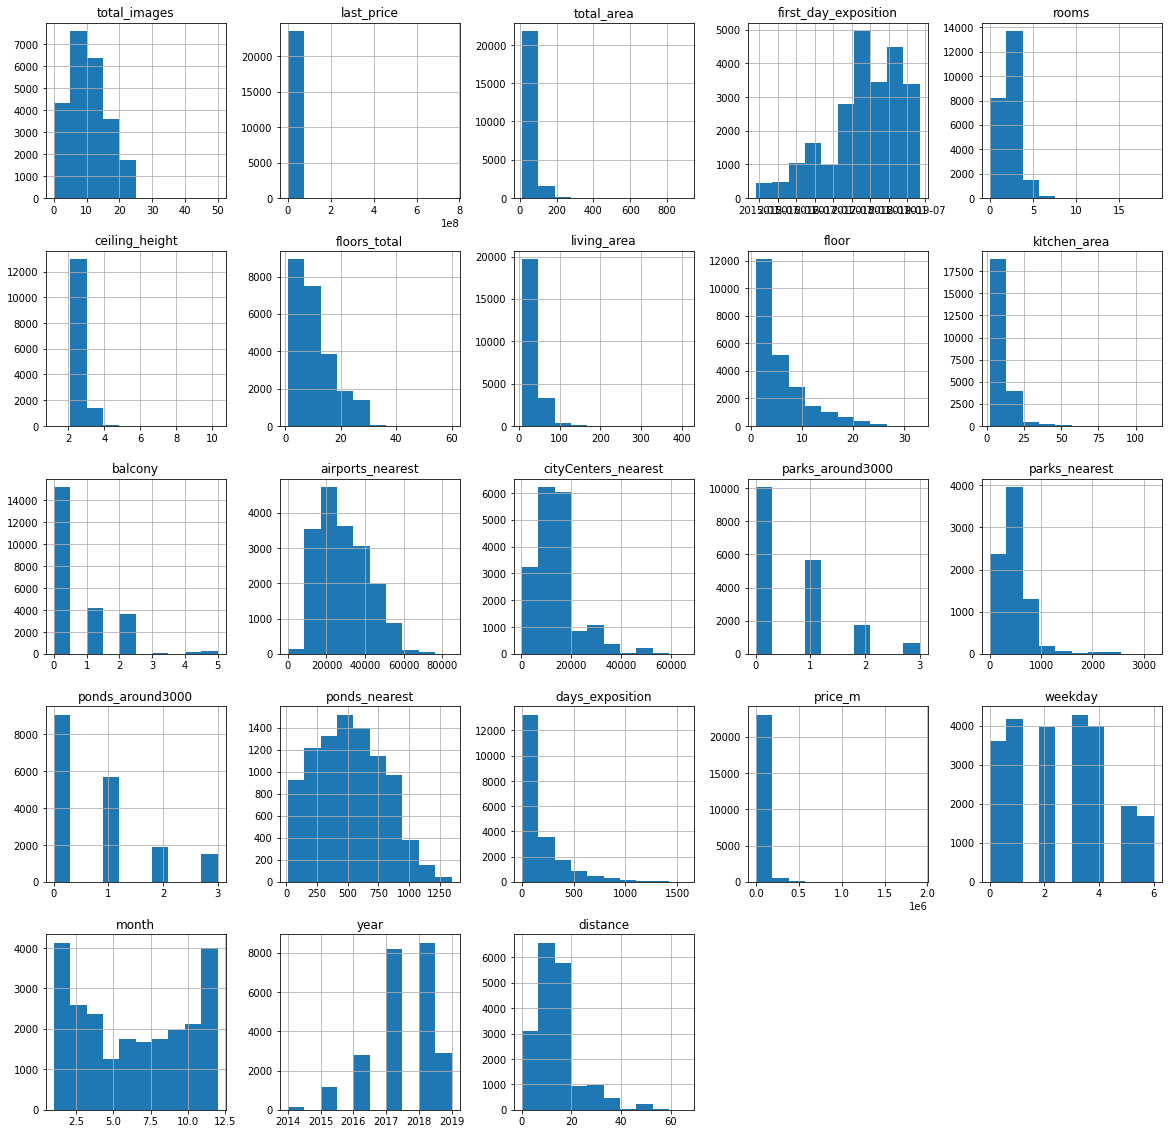

In [33]:
#строю гистрограммы по всем показателям
df.hist(figsize=(20, 20))
plt.show()

#### Выводы

1. Общая площадь большинства продаваемых объектов до 100 квадратных метров
2. Почти 20000 предложений имеют жилую площадь в пределах 50 кв. метров
3. Кухни в большинстве предложений менее 10 кв.м
4. У цены за квардратный метр нет большого разброса, почти все данные находятся в интервале<br>
5. Самые популярные предложения имеют 2-3 комнаты, больше 5 комнат почти не встречается
6. Высота потолков почти во всех предложениях 2.5 - 3 метра
7. Самые популярные предложения находятся до 10 этажа <br>
8. Большинство предложений находится между первым и последним этажом. На первом этаже предложений меньше всего.
9. По общему количеству этажей в доме есть разброс, но большая часть всё же находится в пределах 10 этажа
10. Большая часть всей недвижимости находится в пределах 20 км от центра города<br>
11. Основная часть предложений находится от 10 до 40 км от аэропорта
12. Почти у всех предложений есть парк в пределах 10 километров. У большей части он находится в шаговой доступности, до 5 км.
13. В летние месяцы публикуется меньше всего объявлений<br>




### Анализ того, как быстро продавались квартиры

count    20460.000000
mean       180.783773
std        219.812580
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


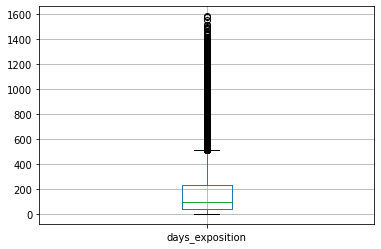

In [34]:
print(df['days_exposition'].describe()) #получение инфы по столбцу
#df.hist(column = 'days_exposition') #постороение гистограммы по столбцу
#plt.show()
df.boxplot(column='days_exposition')
plt.show()

#### Вывод

Средний срок продажи квартиры 180 дней<br>
Половина квартир продается за три месяца (до 95 дней) <br>
Еще четверть продается за 7 месяцев (232 дня)<br>
Получается, что долгой продажей можно назвать недвижимость, которая продается более 7 месяцев

### Факторы, которые больше всего влияют на общую (полную) стоимость объекта

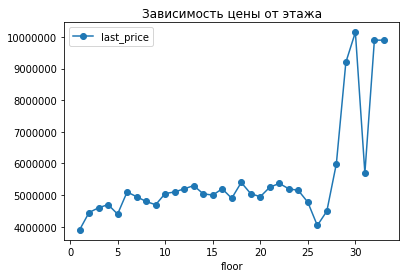

In [35]:
ax = (df.pivot_table(index='floor', values='last_price', aggfunc='median')
      .plot(style='o-', title='Зависимость цены от этажа')
     ) #сводная и график зависимости цены от этажа
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))#изменение формата отображения цены


#### Вывод
Покупатели явно не любят первый этаж, там значения самые минимальные. В остальных значениях резкого разброса нет, кроме непривычно высоких этажей, выше 25.

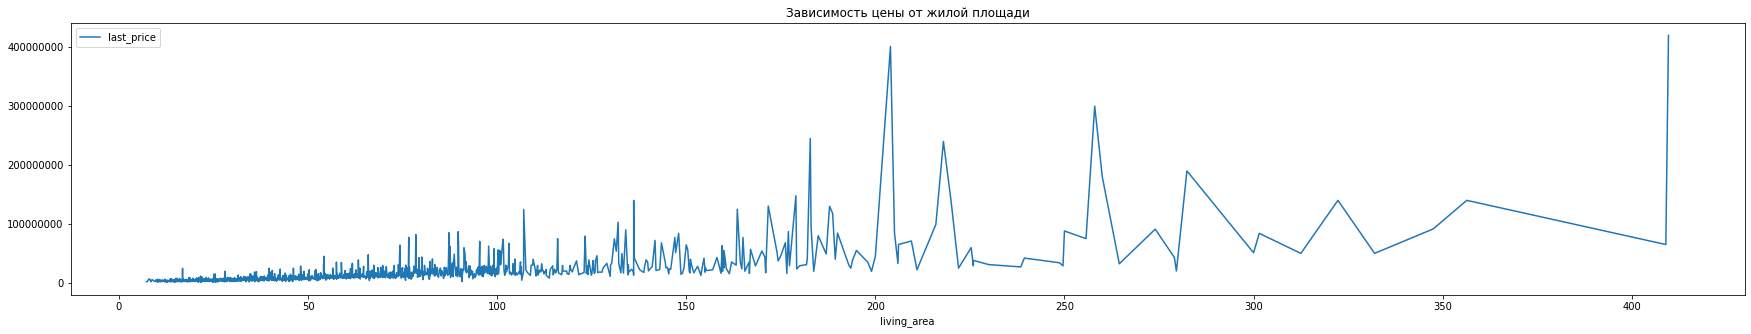

In [36]:
ax = (df.pivot_table(index='living_area', values='last_price', aggfunc='median')
      .plot(style='-', figsize = (30,5), title='Зависимость цены от жилой площади')
     )
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#### Вывод
Видно постепенное пропорциональное увеличение, но при этом очень много скачков. Скорей всего, это обусловлено тем, что в разных населенных пунктах стоимость меняется, поэтому такой показатель корректней сравнивать по стоимости метра, а не общей

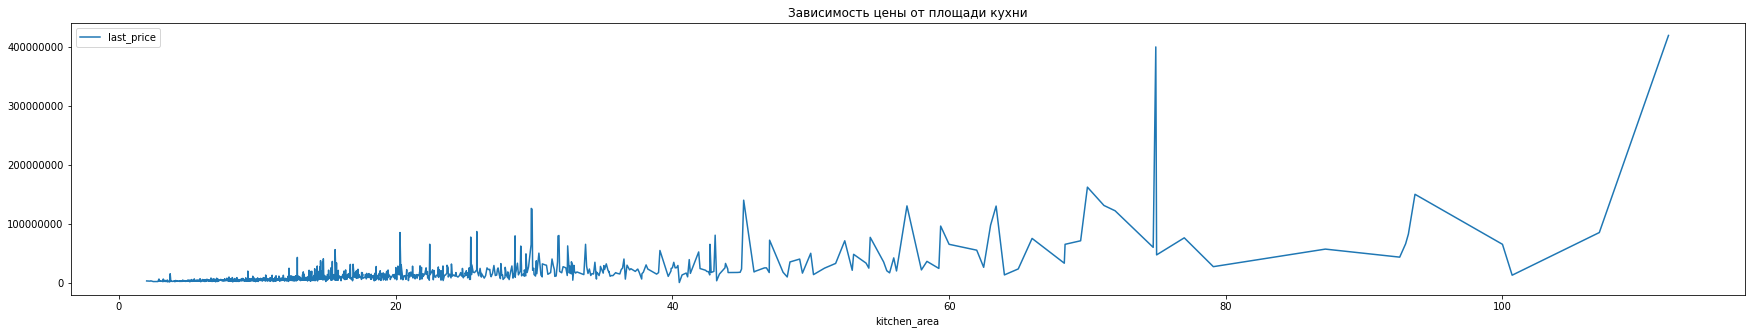

In [37]:
ax = (df.pivot_table(index='kitchen_area', values='last_price', aggfunc='median')
      .plot(style='-', figsize = (30,5), title='Зависимость цены от площади кухни')
     )
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#### Вывод
Видно постоянные скачки на графике и плавное увеличение. Значит, тенденция к увеличению цены от площади кухни есть, но она не явная 

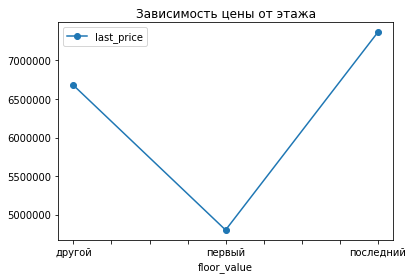

In [38]:
ax = (df.pivot_table(index='floor_value', values='last_price')
      .plot(style='o-', title='Зависимость цены от этажа')
     ) #сводная и график зависимости цены от этажа
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))#изменение формата отображения цены


#### Вывод
Первый этаж совсем не популярен, поэтому цены на эту недвижимость минимальные. А самые высокие цены на последние этажи

In [39]:
df['total_area'].max()

900.0

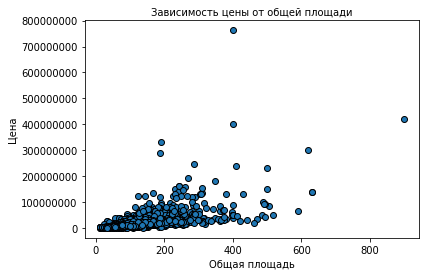

In [40]:
#диаграмма рассеивания для зависимости цены от общей площади
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False, style='plain')
ax.scatter(x = df['total_area'], y= df['last_price'], edgecolor='k')
plt.title("Зависимость цены от общей площади", fontsize=10) 
plt.gca().set(ylabel='Цена', xlabel='Общая площадь')
plt.show()

#### Вывод
Есть небольшая тенденция к повышению цены от повышения площади. Но на графике видно, что есть много предложений, которые равны по стоимости при разных площадях. Это можно объяснить большой разницей в стоимости в зависимости от населенного пункта.

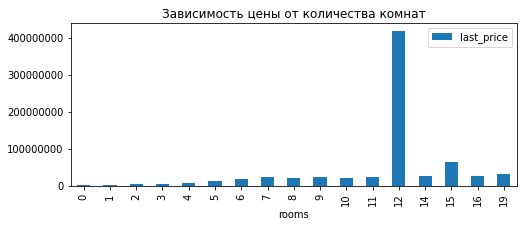

In [41]:
ax = (df.pivot_table(index='rooms', values='last_price', aggfunc='median')
      .plot(kind = 'bar', figsize = (8,3), title='Зависимость цены от количества комнат')
     )
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#### Вывод
Судя по графику, цена напрямую зависит от количества комнат и увеличивается пропорционально. Большая часть всех предложений содержит до трех комнат. В показателе 12 есть пик, но это больше похоже на аномальное значение

In [42]:
print(df.columns)#вывела названия столбцов, чтобы не листать вверх каждый раз


Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_m', 'weekday', 'month',
       'year', 'floor_value', 'distance'],
      dtype='object')


In [43]:
#сохраняю в переменную сводную таблицу, чтобы переменовать индексы на дни недели
df_weekday = df.pivot_table(index='weekday', values='last_price', aggfunc='median')
df_weekday = df_weekday.rename({0:'Понедельник', 1:'Вторник', 2:'Среда',3:'Четверг',4:'Пятница',5:'Суббота',6:'Воскресенье'})


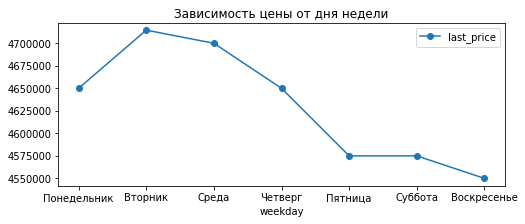

In [44]:
#график зависимости цены от дня недели
ax = (df_weekday
      .plot(style='o-', figsize = (8,3), title='Зависимость цены от дня недели')
     )

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))


#### Вывод
Самый пик стоимости приходится на вторник и снижается к концу недели. Не представляю, как это может быть связано.

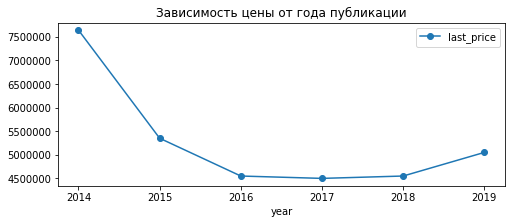

In [45]:
ax = (df.pivot_table(index='year', values='last_price', aggfunc='median')
      .plot(style='o-', figsize = (8,3), title='Зависимость цены от года публикации')
     )
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#### Вывод
После пика в 2014 году, стоимость недвижимости постепенно снижалась. Возможно, это обусловлено, внешнеполитическими событиями 2014 года и скачками курсов. В 2016-2018 году стоимость была стабильна и начала не резко расти в 2019, что может быть результатом инфляции.<br>
Но, в графике может быть искажение, так как ранее было видно, что в 2014 году объявлений было очень мало, соответсвенно, выборка маленькая и может дать не совсем корректный результат

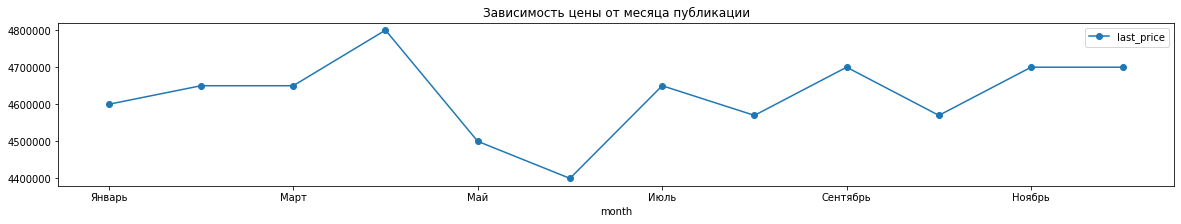

In [46]:
df_month = df.pivot_table(index='month', values='last_price', aggfunc='median')
df_month = df_month.rename({1:'Январь',2:'Февраль',3:'Март',4:'Апрель',5:'Май',6:'Июнь',7:'Июль',8:'Август',9:'Сентябрь',10:'Октябрь',11:'Ноябрь',12:'Декабрь'})
ax = (df_month
      .plot(style='o-', figsize = (20,3), title='Зависимость цены от месяца публикации')
     )
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#### Вывод
Данные говорят о том, что с самыми высокими ценами объявления публикуются в апреле, а с самыми низкими в мае-июне. 


### Средняя цена квардратного метра в разных населенных пунктах


In [47]:
#сортирую по городам с самым большим количеством объявлений и их ценой за кв. м
df_local = df.pivot_table(index = ['locality_name'], values = 'price_m', aggfunc = ['count','mean'])
df_local.columns = ['count', 'mean']
df_local = round(df_local.sort_values('count', ascending = False).head(10),0)
df_local = df_local.head(10)
print(df_local)

                   count      mean
locality_name                     
Санкт-Петербург    15716  114853.0
поселок Мурино       556   85682.0
поселок Шушары       440   78677.0
Всеволожск           397   68719.0
Пушкин               369  103126.0
Колпино              338   75425.0
поселок Парголово    327   90176.0
Гатчина              307   68746.0
деревня Кудрово      299   92474.0
Выборг               235   58238.0


<AxesSubplot:title={'center':'Зависимость цены на квадратный метр от населенного пункта'}, xlabel='locality_name'>

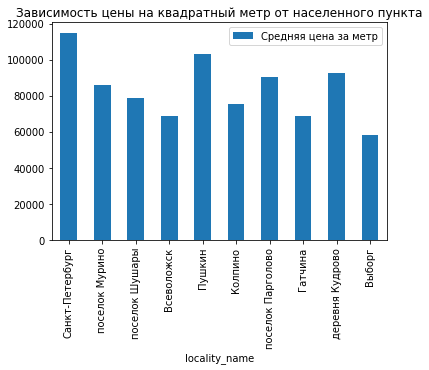

In [48]:
df_local.plot(xlabel='locality_name', y = 'mean',kind = 'bar', label = 'Средняя цена за метр',title='Зависимость цены на квадратный метр от населенного пункта'  )

#### Вывод
Самая высокая средняя цена за квадратный метр в Санкт-Петербурге, к тому же и количество объявлений там самое большое.

### Средняя цена каждого километра


In [49]:
#функция, которая даст имена категориям, в зависимости от расстояния от центра
def nearest(cityCenters_nearest):
    if cityCenters_nearest <= 1000:
        return 'До километра'
    elif   1001 <= cityCenters_nearest <=5000:
        return 'до 5 километров'
    elif 5001 <=cityCenters_nearest <= 10000:
        return '5-10 километров'
    elif 10001 <=cityCenters_nearest <= 20000:
        return '10-20 километров'
    else:
        return 'более 20 километров'
    
df['total_nearest'] = df['cityCenters_nearest'].apply(nearest)

<AxesSubplot:title={'center':'Зависимость цены от расстояния от центра'}, xlabel='total_nearest'>

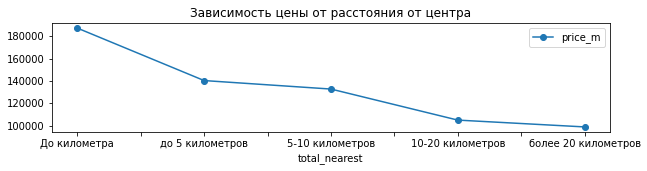

In [50]:
spb_local = df.query('locality_name == "Санкт-Петербург"')#выделяю таблицу только с Питером
spb_local = spb_local.pivot_table(index = 'total_nearest', values = 'price_m', aggfunc = 'mean')
spb_local = round(spb_local.sort_values('price_m', ascending = False),0)
spb_local.plot(style='o-',figsize = (10,2), label = 'Средняя цена за метр',title='Зависимость цены от расстояния от центра')


#### Вывод
Чем дальше от центра - тем дешевле

### Общий вывод
В данных есть много пропусков, а многие из них критично важны для корректного анализа. Поэтому необходимо, чтобы поля "Населенный пункт" и "Общая площадь" были заполнены обязательно. К тому же можно добавить справочник городов, чтобы не было неявных дублей названий. Данные о том, сколько объявление было активно, вероятно, должны считаться автоматически после снятия объявления. Поэтому, тут могут быть проблемы в выгрузке данных.  

В целом можно сказать: 
- Стоимость недвижимости в первую очередь напрямую зависит от населенного пункта и площади. А внутри населенного пункта цена зависит от расстояния до центра. Самое дорогое жилье в Санкт-Петербурге и Пушкино.
- Летом публикуется меньше всего объявлений. 
- Половина всей недвижимости продается быстрее, чем за три месяца.
- Квартиры на первом этаже стоят дешевле других.

Среднестатическое предложение о продаже можно охарактеризовать так:

*Квартира в Санкт-Петербурге, с общей площадью до 100 кв.метров, высотой потолков до 3 метров, кухней в пределах 10 кв.метров, находящаяся не на первом и не на последнем этаже, имеющая 2-3 комнаты и парк в шаговой доступности*